In [ ]:
#|default_exp datasets.sadspheres
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
# from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Saddle Sphere Ablations
> Little brother to the Curvature Colosseum

This is a dataset intended to measure the sign discrimination ability of diffusion curvature and other curvature methods. The dataset consists of different samplings of saddles and spheres with varying intensities of curvature and in varying dimensions. There's also the possibility of adding noise. This notebook implements a class which creates this dataset with specified parameters as well as convenience functions which can be used for testing it and visualizing the results.

# Implementation

Because of the specialized purpose of this dataset, we're wrapping it in a special class, which allows the dataset to evaluate its own fidelity in embeddings.

It works like this:
1. Instatiate the class, supply the dimensions, and noise level, and it will create all of the graphs.
2. To run curvature computations on these graphs, you can extract them directly -- or, you can use the dataset as an *iterator*, loop through, run your own logic within, then run an 'update' function to store the result.
3. Afterwards, you can use the built in methods for visualizing and getting metrics on the performance.

In [ ]:
#|export
from diffusion_curvature.core import get_adaptive_graph
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere
from fastcore.all import *
import xarray as xr
import inspect
import pandas as pd

import sklearn

def metric(func):
    setattr(func, 'tag', 'metric')
    return func

class SadSpheres():
    def __init__(self,
                 dimension = 2, # Dimension of saddles and spheres
                 num_pointclouds = 100, # num pointclouds to make in total
                 num_points = 2000, # num points per pointclouds
                 noise_level = 0, # from 0 to 1. 1 is all noise.
                ):
        store_attr()
        self.DS = xr.Dataset()
        self.idx = -1
        for i in range(num_pointclouds//2):
            X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, self.dimension)
            self.DS[2*i] = xr.DataArray(X_saddle, dims=['n', 'd'], attrs={'ks':ks_saddle})
            X_sphere, ks_sphere = sphere(self.num_points, self.dimension)
            self.DS[2*i+1] = xr.DataArray(X_sphere, dims=['n', 'd'], attrs={'ks':ks_sphere[0]})
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.num_pointclouds

    def __next__(self):
        self.idx += 1
        if self.idx >= self.num_pointclouds:
            raise StopIteration
        result = self.DS[self.idx].to_numpy()
        return result

    def update(self,
               result,
               method_name='computed'):
        """
        Store the result of the curvature computation by passing the computed curvature of the center (first) point.
        """
        self.DS[self.idx].attrs[method_name] = result

    def compute_metrics(self):
        self._aggregate_labels()
        metrics = self._get_metrics()
        self.metric_table = {}
        for metric in metrics:
            self.metric_table[metric.__name__] = {}
            for method_name in self.method_names:
                self.metric_table[metric.__name__][method_name] = self.compute(metric=metric, method_name=method_name)
            print(self.metric_table)
        self.metric_table = pd.DataFrame(self.metric_table)
            
    def compute(self, metric, method_name):
        # Overwrite this class with your logic. It implements the computation of a single metric for a single method
        return metric(self.labels[method_name], self.labels['ks'])
    

    def _aggregate_labels(self):
        self.method_names = self.DS.data_vars[0].attrs.keys()
        self.labels = {}
        for m in self.method_names:
            self.labels[m] = np.array([self.DS.data_vars[i].attrs[m] for i in range(self.num_pointclouds)])

    def plot(self, title = ""):
        # for each computed method on this dataset, we plot the histogram of saddles vs spheres
        self._aggregate_labels()
        for m in self.method_names: 
            if m is not 'ks':
                plt.hist(self.labels[m][0::2], bins=50, color='orange', label = 'Saddles')
                plt.hist(self.labels[m][1::2], bins=50, color='green', label = 'Spheres')
                plt.legend()
                plt.xlabel(m)
                plt.title(f"In dimension {self.dimension}")
                plt.show()

    def table(self):
        self.compute_metrics()
        return self.metric_table

    def _get_metrics(self):
        tagged_functions = []
        for name, member in inspect.getmembers(self, predicate=inspect.ismethod):
            if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
                tagged_functions.append(member)
        return tagged_functions

    @metric
    def mutual_info(self, a, b):
        return sklearn.metrics.mutual_info_score(a, b)

    @metric
    def sign_score(self, a, b):
        # measures the extent to which the sign of a agrees with b
        return sklearn.metrics.mutual_info_score(
            np.sign(a),
            np.sign(b),
        )
        
    

In [ ]:
SS = SadSpheres()
for X in SadSpheres():
    break

In [ ]:
ks_combined = SS.DS.data_vars

In [ ]:
d.attrs['ks'] for d in DS.data_vars

{'ks': -8.0}

In [ ]:
SS.DS.data_vars[0].attrs.keys()

dict_keys(['ks'])

# Tests

In [ ]:
from diffusion_curvature.core import *

In [ ]:
SS = SadSpheres(
    dimension = 2, # Dimension of saddles and spheres
    num_pointclouds = 10, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)
graph_former = get_adaptive_graph
for X in tqdm(SS):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    SS.update(ks[0], method_name="Diffusion Entropic Curvature")
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    SS.update(ks[0], method_name="Diffusion Wasserstein Curvature")

  0%|          | 0/10 [00:00<?, ?it/s]

2024-02-20 13:01:01,278:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:01,644:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:02,021:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:02,493:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:02,791:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:03,167:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:03,636:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:04,022:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-02-20 13:01:04,395:[WARNING](pygsp.graphs.graph.che

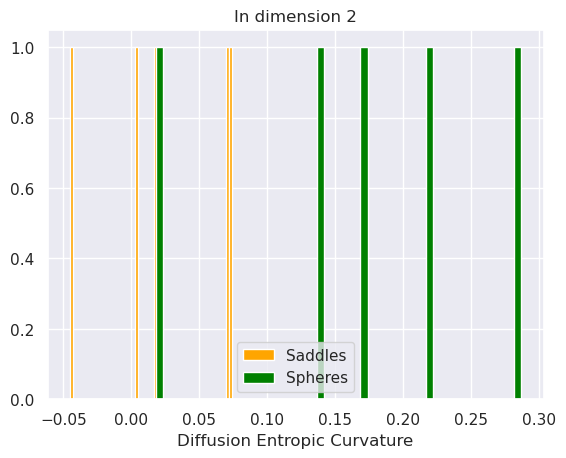

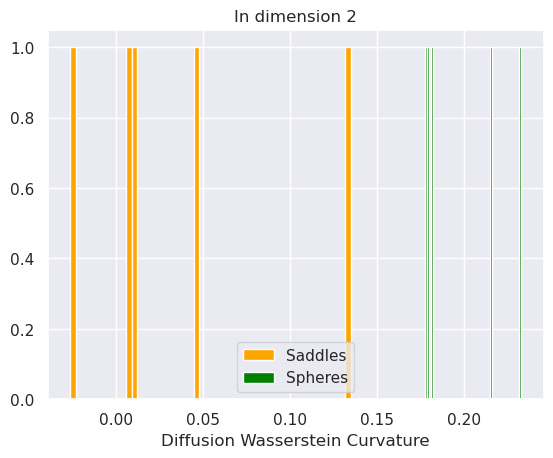

In [ ]:
SS.plot()

In [ ]:
SS.compute_metrics()

{'mutual_info': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.6931471805599454, 'Diffusion Wasserstein Curvature': 0.6931471805599454}}
{'mutual_info': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.6931471805599454, 'Diffusion Wasserstein Curvature': 0.6931471805599454}, 'sign_score': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.0748817616223546, 'Diffusion Wasserstein Curvature': 0.0748817616223546}}


In [ ]:
SS.table()

{'mutual_info': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.6931471805599454, 'Diffusion Wasserstein Curvature': 0.6931471805599454}}
{'mutual_info': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.6931471805599454, 'Diffusion Wasserstein Curvature': 0.6931471805599454}, 'sign_score': {'ks': 0.6931471805599456, 'Diffusion Entropic Curvature': 0.0748817616223546, 'Diffusion Wasserstein Curvature': 0.0748817616223546}}


,mutual_info,sign_score
ks,0.693147,0.693147
Diffusion Entropic Curvature,0.693147,0.074882
Diffusion Wasserstein Curvature,0.693147,0.074882


In [ ]:
SS.mutual_info(np.ones_like(SS.labels['ks']),np.ones_like(SS.labels['ks']))

0.0

In [ ]:
for name, member in inspect.getmembers(SS, predicate=inspect.ismethod):
    if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
        print(name)

mutual_info
sign_score


In [ ]:
inspect.getmembers(SS, predicate=inspect.ismethod)

[('__init__',
  <bound method SadSpheres.__init__ of <__main__.SadSpheres object>>),
 ('__iter__',
  <bound method SadSpheres.__iter__ of <__main__.SadSpheres object>>),
 ('__len__',
  <bound method SadSpheres.__len__ of <__main__.SadSpheres object>>),
 ('__next__',
  <bound method SadSpheres.__next__ of <__main__.SadSpheres object>>),
 ('_aggregate_labels',
  <bound method SadSpheres._aggregate_labels of <__main__.SadSpheres object>>),
 ('_get_metrics',
  <bound method SadSpheres._get_metrics of <__main__.SadSpheres object>>),
 ('compute',
  <bound method SadSpheres.compute of <__main__.SadSpheres object>>),
 ('compute_metrics',
  <bound method SadSpheres.compute_metrics of <__main__.SadSpheres object>>),
 ('mutual_info',
  <bound method SadSpheres.mutual_info of <__main__.SadSpheres object>>),
 ('plot',
  <bound method SadSpheres.plot of <__main__.SadSpheres object>>),
 ('sign_score',
  <bound method SadSpheres.sign_score of <__main__.SadSpheres object>>),
 ('table',
  <bound method 

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync